### I. INTRODUCTION

*Name: Nurfiah Idris*  
*Batch: 005*  
*Assignment: Milestone 1 / Phase 2*

***About Dataset***

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service.

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

1. Customers who left within the last month – the column is called Churn.
2. Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.
3. Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.
4. Demographic info about customers – gender, age range, and if they have partners and dependents.

More about dataset can be found in [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn).

***Objective***

This project exists to build Artificial Neural Network (ANN) model to predict customers churned behaviour on Telco product based on given information.

### II. IMPORT LIBRARY

In [1]:
# standard 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from custom_transformer import column_transformer

# modelling
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow  import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import confusion_matrix


### III. DATA LOADING

In [2]:
# Read data from source
df_raw = pd.read_csv('telco_churn.csv')
X = df_raw.copy()
X.shape

(7043, 21)

In [3]:
X.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
# Liken column name as PascalCase
X.rename(columns = {'customerID':'CustomerID','gender':'Gender', 'tenure':'Tenure'}, inplace = True)
# Encode target column.
X['Churn'] = X['Churn'].replace({"No":0, "Yes":1})

***Splitting Data***

In [5]:
# Split data into train, test and validation.
train, test = train_test_split(X, test_size = 0.15, stratify = X.Churn)
train, val = train_test_split(train, test_size = 0.15, stratify = train.Churn)
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Validation data shape: {val.shape}")

Train data shape: (5088, 21)
Test data shape: (1057, 21)
Validation data shape: (898, 21)


### IV. DATA CLEANING

***Find Missing and Duplicated Value***

In [6]:
# Create function for check missing value, unique value, datatype
def show_general_table(data):
    
    # Find dataset types.
    dataset_info = data.dtypes.reset_index()
    dataset_info = dataset_info.rename(columns={'index': 'column_name',0:'type'})
    # Find dataset total uniques.
    uniques= data.nunique().reset_index()
    uniques = uniques.rename(columns = {0:'unique'})
    dataset_info['unique'] = uniques['unique']
    # Find dataset misisng values.
    data = data.replace(' ', np.nan)
    data = data.replace('', np.nan)
    missing = data.isnull().sum()/data.shape[0]*100
    missing = missing.reset_index().rename(columns = {0:'missing'})
    dataset_info['missing %'] = missing['missing']
    # Find duplicate values.
    duplicate = data.duplicated().reset_index()
    duplicate = duplicate.rename(columns = {0: 'duplicated'})
    dataset_info['duplicated'] = duplicate['duplicated']
    print(dataset_info)

In [7]:
# missing values on all data
show_general_table(X)

         column_name     type  unique  missing %  duplicated
0         CustomerID   object    7043   0.000000       False
1             Gender   object       2   0.000000       False
2      SeniorCitizen    int64       2   0.000000       False
3            Partner   object       2   0.000000       False
4         Dependents   object       2   0.000000       False
5             Tenure    int64      73   0.000000       False
6       PhoneService   object       2   0.000000       False
7      MultipleLines   object       3   0.000000       False
8    InternetService   object       3   0.000000       False
9     OnlineSecurity   object       3   0.000000       False
10      OnlineBackup   object       3   0.000000       False
11  DeviceProtection   object       3   0.000000       False
12       TechSupport   object       3   0.000000       False
13       StreamingTV   object       3   0.000000       False
14   StreamingMovies   object       3   0.000000       False
15          Contract   o

TotalCharges column values are numerical but it's data type is categorical hence I will transform TotalCharges column into numerical type at first and fill the null value with the same amount of MonthlyCharges.

In [8]:
data_list = [train,test,val]
data_name = ['training','testing','validation']
for i, data in enumerate(data_list):
    # Transform TotalCharges into numerical.
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')
    # Fill missing value on TotalCharges.
    data['TotalCharges'].fillna(data['MonthlyCharges'],inplace=True)
    print(f"Missing value on data {data_name[i]} is: {data['TotalCharges'].isnull().sum()}")

Missing value on data training is: 0
Missing value on data testing is: 0
Missing value on data validation is: 0


Here I will just drop customerId column since each rows have different unique value which means that it has no predictive power in classifying purpose.

In [9]:
# Drop customerId column.
for i, col in enumerate(data_list):
    data_list[i].drop('CustomerID', inplace=True, axis=1)

Now, I will have a look all unique values of all categorical columns with total unique value equal 3 or 4.

In [10]:
# Check unique values
for col in train.select_dtypes('object').columns:
    print(f"{col}: {train[col].unique()}")

Gender: ['Male' 'Female']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['Yes' 'No']
MultipleLines: ['Yes' 'No' 'No phone service']
InternetService: ['Fiber optic' 'DSL' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['No' 'Yes' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['Yes' 'No' 'No internet service']
Contract: ['Month-to-month' 'Two year' 'One year']
PaperlessBilling: ['No' 'Yes']
PaymentMethod: ['Electronic check' 'Bank transfer (automatic)' 'Mailed check'
 'Credit card (automatic)']


We noticed that the class for "No phone serivice" and "No internet service" means "No", hence to avoid redundancy class in every column with these class, I will just replace it all with "No".

In [11]:
for i, col in enumerate(data_list):
    data_list[i].replace({"No phone service": "No"}, inplace=True)
    data_list[i].replace({"No internet service": "No"},inplace=True)

In [12]:
# Recheck unique values after editing
for col in train.select_dtypes('object').columns:
    print(f"{col}: {train[col].unique()}")

Gender: ['Male' 'Female']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['Yes' 'No']
MultipleLines: ['Yes' 'No']
InternetService: ['Fiber optic' 'DSL' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['No' 'Yes']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['Yes' 'No']
Contract: ['Month-to-month' 'Two year' 'One year']
PaperlessBilling: ['No' 'Yes']
PaymentMethod: ['Electronic check' 'Bank transfer (automatic)' 'Mailed check'
 'Credit card (automatic)']


### V. DATA EXPLORATION

***Exploration on Train Data***

In this section, I will gain some insight from this dataset. Here what I am going to find out:
1. The correlation between tenure and total charges and it's tendency to churn.
2. Customer with what kind of payments tends to churn.
3. Is contract type affect customer behaviour on churn the product.
4. Is amount of monthly charges have something to do with churn.
5. What kind of customer that tend to churn.

In [13]:
show_general_table(train)

         column_name     type  unique  missing %  duplicated
0             Gender   object       2        0.0       False
1      SeniorCitizen    int64       2        0.0       False
2            Partner   object       2        0.0       False
3         Dependents   object       2        0.0       False
4             Tenure    int64      73        0.0       False
5       PhoneService   object       2        0.0       False
6      MultipleLines   object       2        0.0       False
7    InternetService   object       3        0.0       False
8     OnlineSecurity   object       2        0.0       False
9       OnlineBackup   object       2        0.0       False
10  DeviceProtection   object       2        0.0       False
11       TechSupport   object       2        0.0       False
12       StreamingTV   object       2        0.0       False
13   StreamingMovies   object       2        0.0       False
14          Contract   object       3        0.0       False
15  PaperlessBilling   o

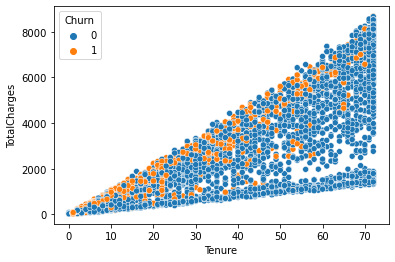

In [14]:
# Correlation between Tenure and TotalCharges
sns.scatterplot(data= train, y='TotalCharges', x='Tenure', hue='Churn');

- Tenure and TotalCharges have the positive correlation.
- Most likely, the customer with small tenure and total chargers aswell have high chances to churn which means that the customers whose just recently joined and surely still have few amount of TotalCharges tends to leave or end their subscription.

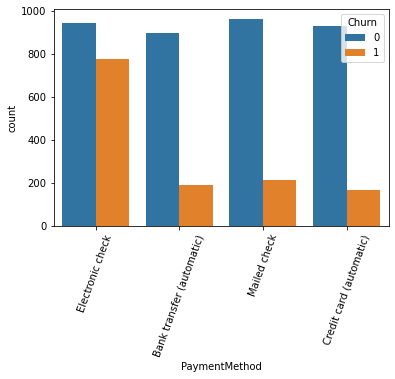

In [15]:
# Correlation between PaymentMethod and Churn
sns.countplot(data = train, x='PaymentMethod', hue='Churn');
plt.xticks(rotation = 70)
plt.show()

- According to customer payment method, those whose using electronic check for payment many times churned from product compare to those using traditional method or even credit card user.

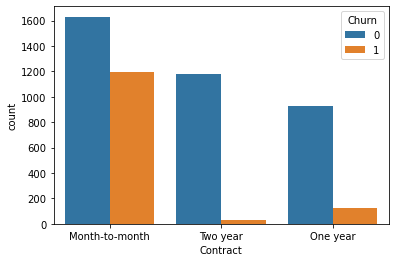

In [16]:
# Correlation between Contract and Churn
sns.countplot(data = train, x='Contract', hue='Churn');

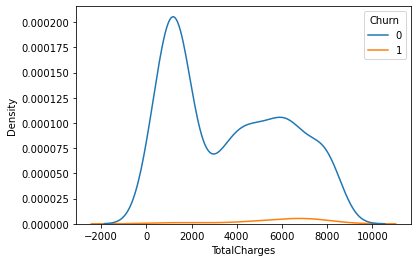

In [17]:
data = train[train['Contract'] == 'Two year']
sns.kdeplot(data=data, x="TotalCharges", hue='Churn');

- The customer whose contract type is month-to-month more often end their subscription to the telco product while other contract type most likely stay and continue to use the product and they consider as loyal customer. It might because month to month contract is easier to stop subscribe then yearly contract they need to wait yearly to stop their subscription.
- Almost the customer with contract type is Two Year keep continuing using the product but some of them with total charges between 4000 and 10000 still consider to churned.
- Therefore, for marketing purposes it will be better for the company to attract new customer to subscribe yearly by giving them special discount.

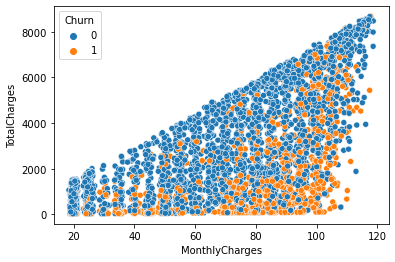

In [18]:
# Correlation between MonthlyCharges and TotalCharges
sns.scatterplot(data=train, x='MonthlyCharges', y='TotalCharges', hue='Churn');

- Most of the customer with high monthly amount of charges choosed to stop being customer of this company.

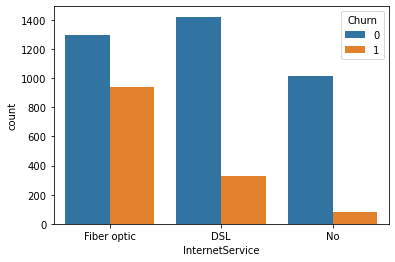

In [19]:
sns.countplot(data=train, x='InternetService', hue='Churn');

In [20]:
# Check the customer without internet service
data = train[(train['InternetService'] == 'No')]
print(f"OnlineSecurity: {data['OnlineSecurity'].unique()}")
print(f"TechSupport: {data['TechSupport'].unique()}")

OnlineSecurity: ['No']
TechSupport: ['No']


- The customer who use Fiber optic as internet service most likely choose to leave the product compare to them that use DSL.
- As we know that Telco is a company that provided home phone and Internet services, however there are still some people that keep subscribes the product even they did not use any internet service or other service like online services and there is no techsupport aswell which means probably they subscribed only for home phone services.

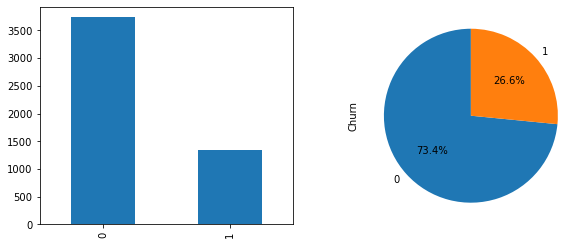

In [21]:
# Display target proportion.
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
train['Churn'].value_counts().plot(kind='bar', ax=axs[0])
train['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[1])
plt.show()

- We can say that this dataset is classified as imbalanced dataset since the ratio between class on target column is quite far. It is 73.4 % instances classified as No on churn and remaining is Yes class which is only 26.6 %.

### VI. DATA PREPROCESSING

***Feature Engineering***

In order to see Pearson correlation between all features we need to transform all column to numerical. Let's encode all categorical column first using LabelEncoder.

In [22]:
# Encode all categorical column.
cat_col = list(train.select_dtypes('object').columns)
corr_data = train.copy()
le = LabelEncoder()
for j,col in enumerate(cat_col):
    arr = le.fit_transform(corr_data[col])
    corr_data[col] = arr
corr_data.head(3)


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5027,1,1,1,0,10,1,1,1,0,0,0,0,0,1,0,0,2,85.55,851.75,1
4890,1,0,1,1,53,1,0,1,0,1,0,1,1,0,0,1,2,92.55,4779.45,0
4184,1,1,1,0,5,1,1,1,0,0,1,0,0,0,0,1,0,79.90,343.95,1


In [23]:
corr_data.to_csv('corr_data.csv',index=False)

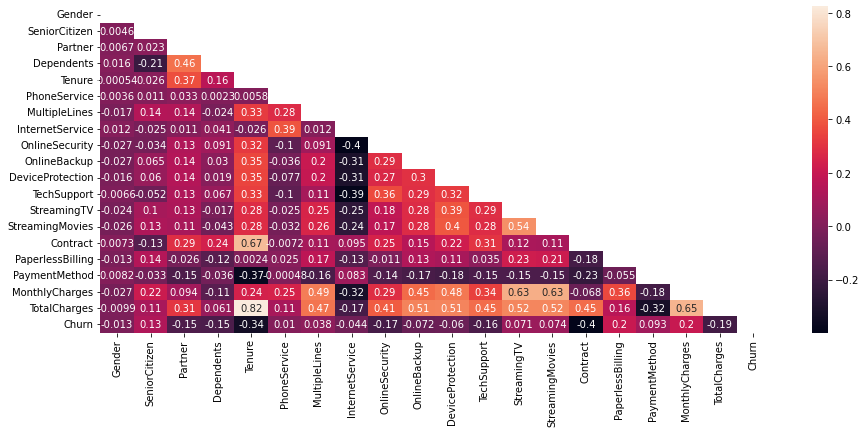

In [24]:
# Display correlation among features using Pearson method with heatmap plotting
corr = corr_data.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot= True, mask = np.triu(corr));

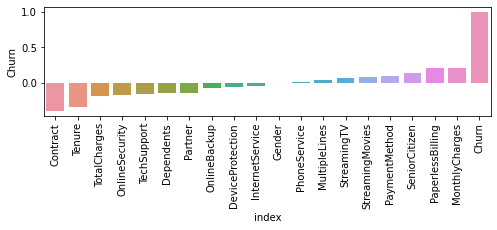

In [25]:
# Direct correlation to target column
direct_corr = corr['Churn'].reset_index().sort_values(ascending=True, by=['Churn'])
plt.figure(figsize = (8,2))
sns.barplot(data = direct_corr, y= 'Churn', x= 'index')
plt.xticks(rotation = 90)
plt.show()

As we can see above, according to pearson correlation that Contract and Tenure have the most predictive power while Gender and PhoneService almost have no correlation with Churn. What about using feature importance of RandomForestClassifier model. Now, let's find out which feature is the most importance according to this model.

***Data Scalling***

In [26]:
# Scalling and normalize data using standar scaller
scaller = StandardScaler()
X_train = corr_data.drop('Churn', axis=1)
y_train = corr_data.Churn
X_train = scaller.fit_transform(X_train)

***Feature Importance***

In [27]:
# Define and train randomforestclassifier model to find the most importance features using it's feature_importance method.
ranfor = RandomForestClassifier(n_estimators=10, max_leaf_nodes=16, random_state=42)
ranfor.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=10, random_state=42)

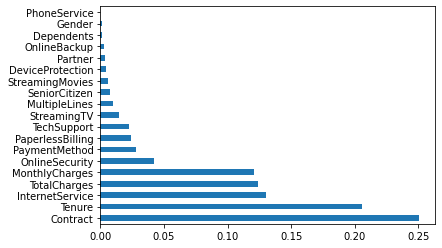

In [28]:
# Plot graph of feature imprtances for better visualization.
feat_importances_rand = pd.Series(ranfor.feature_importances_, index =train.drop('Churn', axis = 1).columns)
feat_importances_rand.nlargest(20).plot(kind = "barh")
plt.show()

In [29]:
# Drop unimportance features.
drop_col = ['OnlineBackup','Dependents','DeviceProtection','Partner','Gender','StreamingMovies','PhoneService','StreamingTV']
for i, col in enumerate(data_list):
    data_list[i].drop(drop_col, axis=1, inplace=True)


In [30]:
train.to_csv('clean_data.csv', index=False)
val.to_csv('validation_data.csv', index=False)

By using feature_importance() method from RandomForestClassifier model, we found that the most powerful predictors of this data train are Tenure, Contract, InternetService, TotalCharges, TechSupport and MonthlyCharges which is quite the same with the result of Pearson correlation method. Both methods also similarly showed that Gender and PhoneService are the lowest predictors we have in this dataset.

Now, I am willing to have a look at data distribution in 2 dimensional features to find out whether the data consists of outlier or not. In order to do so, I will use PCA to reduce dimension of the data.

In [31]:
# Define and train PCA
pca = PCA(n_components=2)
pca_data =pca.fit_transform(X_train)

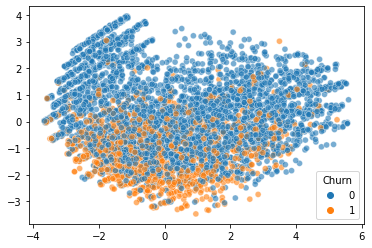

In [32]:
# Display data distribution in 2 dimentional data.
sns.scatterplot(data=pca_data, x=pca_data[:,0], y=pca_data[:,1],hue=y_train, alpha=0.6);

Based on this distribution, there is no outlier to worry about. So, I'll just leave it as is and do nothing on handling outlier.

***Data Preprocessing***

In [33]:
train.head()

,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5027,1,10,Yes,Fiber optic,No,No,Month-to-month,No,Electronic check,85.55,851.75,1
4890,0,53,No,Fiber optic,No,Yes,Month-to-month,Yes,Electronic check,92.55,4779.45,0
4184,1,5,Yes,Fiber optic,No,No,Month-to-month,Yes,Bank transfer (automatic),79.90,343.95,1
2554,0,18,No,DSL,No,No,Month-to-month,Yes,Mailed check,50.00,892.70,0
6905,0,30,No,DSL,No,No,Month-to-month,Yes,Electronic check,44.50,1307.80,0


We have only 3 columns that have different scale, they are Tenure, MonthlyCharges, and TotalCharges column. In order to make it the same as others, I will transform these 3 columns value in range 0 to 1 using MinMaxScaler, and transform categorial using onehotencoder.

I have made the column transformer and saved it to ther other files in order to be able to use it on deployment file.

In [34]:
# Scalling using created custom transformer
transformer = column_transformer()


In [35]:
# Create data train pipeline.
X_train = train.drop('Churn', axis=1)
y_train = train.Churn
X_train = transformer.fit_transform(X_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.repeat(10).batch(50)

2021-12-19 22:56:30.903574: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 22:56:30.904183: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [36]:
train.head()

,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5027,1,10,Yes,Fiber optic,No,No,Month-to-month,No,Electronic check,85.55,851.75,1
4890,0,53,No,Fiber optic,No,Yes,Month-to-month,Yes,Electronic check,92.55,4779.45,0
4184,1,5,Yes,Fiber optic,No,No,Month-to-month,Yes,Bank transfer (automatic),79.90,343.95,1
2554,0,18,No,DSL,No,No,Month-to-month,Yes,Mailed check,50.00,892.70,0
6905,0,30,No,DSL,No,No,Month-to-month,Yes,Electronic check,44.50,1307.80,0


In [37]:
val.head()

,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1324,0,4,No,No,No,No,Month-to-month,No,Mailed check,20.35,76.35,1
1943,0,1,Yes,DSL,No,No,Month-to-month,Yes,Credit card (automatic),49.80,49.80,0
3977,0,63,No,Fiber optic,Yes,Yes,Two year,Yes,Credit card (automatic),110.10,6705.70,0
2698,0,2,No,No,No,No,Month-to-month,No,Mailed check,19.85,51.60,0
4117,0,63,No,Fiber optic,Yes,No,Two year,No,Credit card (automatic),99.70,6330.40,0


In [38]:
# Create data validation pipeline.
X_val = val.drop('Churn', axis=1)
y_val = val.Churn
X_val = transformer.transform(X_val)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.repeat(10).batch(50)

### VII. DEFINE, TRAIN, AND EVALUATE MODEL

In [39]:
X_train.shape[1:]

(22,)

***Sequential API Model***

In [40]:
# Define sequential API architecture model
model = Sequential([
    keras.layers.Dense(12,activation = 'relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(6, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

In [41]:
# Have a look model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                276       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Define configuration for loss, metrics, and optimizer
model.compile(loss = 'binary_crossentropy', optimizer ='adam',metrics=['accuracy'])

In [43]:
# Train sequential model
history = model.fit(train_dataset, validation_data = val_dataset)

   1018/Unknown - 3s 3ms/step - loss: 0.4475 - accuracy: 0.7788

2021-12-19 22:56:33.855754: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


1018/1018 [==============================] - 3s 3ms/step - loss: 0.4475 - accuracy: 0.7788 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [44]:
print(f"Training's loss value: {history.history['loss']}")
print(f"Training's accuracy value: {history.history['accuracy']}")
print(f"Validation's loss value: {history.history['val_loss']}")
print(f"Validation's accuracy value: {history.history['val_accuracy']}")

Training's loss value: [0.4474925039066646]
Training's accuracy value: [0.7787736]
Validation's loss value: [0.41162928409046595]
Validation's accuracy value: [0.8195991]


***Model Improvement***

For model improvement I will train functional architecture model using data without pipeline.

In [45]:
# Preparing data train
X_train = transformer.fit_transform(train.drop('Churn', axis=1))
y_train = np.array(train.Churn)

# Preparing data validation
X_val = transformer.transform(val.drop('Churn', axis=1))
y_val = np.array(val.Churn)

Here I am going to do normalization at the input layers and add dropout before output.

In [46]:
# Create functional model's architecture
inputs = keras.Input(shape=X_train.shape[1:])
batch_norm_1 = layers.BatchNormalization()(inputs)
hidden_1 = layers.Dense(8, activation='elu')(batch_norm_1)
hidden_2 = layers.Dense(4, activation='elu')(hidden_1)
dropout = layers.Dropout(0.3)(hidden_2)
outputs = layers.Dense(1, activation='sigmoid',kernel_initializer="he_normal")(dropout)

model_func = keras.Model(inputs=inputs, outputs=outputs)

In [47]:
model_func.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 22)                88        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 184       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 313
Trainable params: 269
Non-trainable params: 44
______________________________________________________________

In [48]:
# Define training configuration for optimizer, loss, and metrics
model_func.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# Train model
history_func = model_func.fit(X_train,y_train, validation_data = (X_val, y_val), epochs = 32, batch_size = 100, verbose = 0)

In [50]:
# Create function plotting for model tracking
def plot_model_eval(data):
    pd.DataFrame(data.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

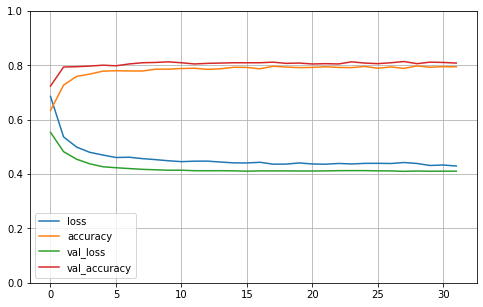

In [51]:
# Tracking history of functional model
plot_model_eval(history_func)

***Model Evaluation***

In [52]:
# Evaluate model
val_value= model_func.evaluate(X_val, y_val,verbose=0)
print(f"Validation's loss value: {val_value[0]}")
print(f"Validation's accuracy value: {val_value[1]}")

Validation's loss value: 0.41061742640285026
Validation's accuracy value: 0.8084632754325867


Text(0.5, 1.0, 'Confusion Matrix')

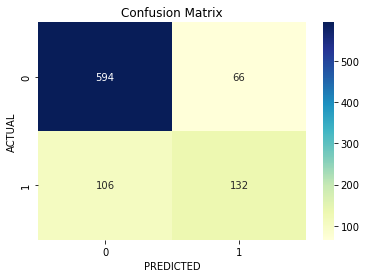

In [53]:
# Confusion matrix using scikitlearn
def func(num):
    if num >0.50:
        return 1
    else:
        return 0
predict = pd.DataFrame(model_func.predict(X_val))[0].apply(func)
actual = y_val
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(actual,predict), annot=True, cmap="YlGnBu", fmt='g', ax=ax)
ax.set_xlabel('PREDICTED')
ax.set_ylabel('ACTUAL')
ax.set_title('Confusion Matrix')

***Model Improvement by Handling Imbalanced Data using Smote***

In [55]:
# Prepared data
cat_col = ['MultipleLines','InternetService','OnlineSecurity','TechSupport','Contract','PaperlessBilling','PaymentMethod',]
smote_data = train.copy()
le = LabelEncoder()
for j,col in enumerate(cat_col):
    arr = le.fit_transform(smote_data[col])
    smote_data[col] = arr

In [56]:
smote_data.sample()

,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3187,0,34,0,1,0,0,0,1,2,89.85,3091.75,0


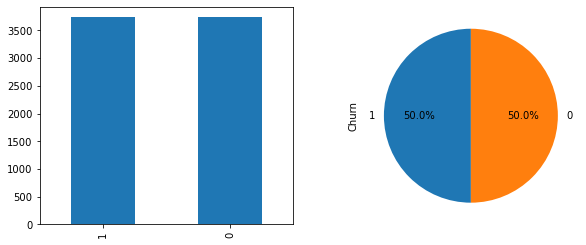

In [57]:
smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(smote_data.drop('Churn', axis=1), smote_data.Churn)
x_smote['Churn']= y_smote
# Display target proportion of smote result.
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
x_smote['Churn'].value_counts().plot(kind='bar', ax=axs[0])
x_smote['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[1])
plt.show()

In [58]:
# Check shape
print(f"Shape before smote: {train.shape}")
print(f"Shape after smote:{x_smote.shape}")

Shape before smote: (5088, 12)
Shape after smote:(7474, 12)


In [59]:
# Preprared data
X_smote = x_smote.drop('Churn', axis=1)
y_smote = np.array(x_smote.Churn)
prepared_data = transformer.fit_transform(X_smote) 
history_smote = model_func.fit(prepared_data, y_smote, validation_data = (X_val,y_val), epochs=32, batch_size=100, verbose=0)

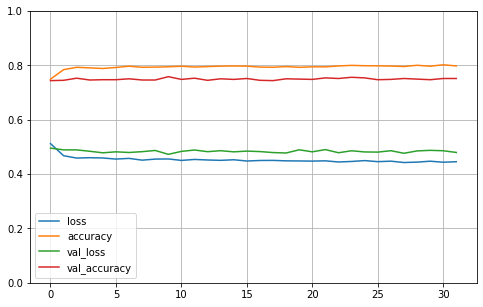

In [60]:
# Plot tracking history
plot_model_eval(history_smote)

In [61]:
# Evaluate model
val_value= model_func.evaluate(X_val, y_val,verbose=0)
print(f"Validation's loss value: {val_value[0]}")
print(f"Validation's accuracy value: {val_value[1]}")

Validation's loss value: 0.4795729494041749
Validation's accuracy value: 0.7516703605651855


Model accuracy is decreasing after train with smote data to handle imbalancing. Using smote method to handle imbalance data is not really helping to improve model performance in this dataset. Finally, I will just use model built with Functional API as my last model since its accuracy is the highest.

Now, I wonder about the model performance when using traditional machine learning for this dataset. Let's just quickly use simple LogisticRegression model from scikit learn to find out and compare the accuracy value with our ANN model.

In [62]:
# Define model.
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
# Prepare data
X_train = transformer.fit_transform(train.drop('Churn', axis=1))
# Train model
logreg.fit(X_train,train.Churn)
# Predit validation data
y_pred = logreg.predict(X_val)
# Accuracy score
acc_score = accuracy_score(y_val, y_pred)
# Cross validation score
score = cross_val_score(logreg, X_train,train.Churn,cv=5).mean()
print(f"Accuracy score: {acc_score}")
print(f"Cross validation mean score: {score}")

Accuracy score: 0.8162583518930958
Cross validation mean score: 0.7932365889891491


### VIII. MODEL SAVING

Becase I have train model with smote data, I will retrain it with the original data before saving it as my last model.

In [63]:
# Retrain model
history_func = model_func.fit(X_train,y_train, validation_data = (X_val, y_val), epochs = 32, batch_size = 100, verbose = 0)

In [64]:
# Saving model for deployment.
model_func.save("my_keras_model.h5")
##### This is how to reuse model with other dataset #######
# loaded_model = keras.models.load_model("my_keras_model.h5")
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
# history = model.fit(train_dataset, epochs=100,
#                     validation_data=val_dataset,
#                     callbacks=[checkpoint_cb, early_stopping_cb])

### IX. MODEL INFERENCE

In this section I will use and load model which has been saved before to predict data testing that I kept at very first step on this project above.

In [65]:
# Load data test
test_data = test.drop('Churn', axis=1)
# Prepare data for prediction using the same transformer used in train data above
scalled_test = transformer.transform(test_data)
test_data.head()

,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5396,0,35,No,No,No,No,One year,Yes,Credit card (automatic),20.10,644.50
5686,1,6,No,Fiber optic,Yes,No,Month-to-month,Yes,Bank transfer (automatic),85.15,503.60
3659,0,67,Yes,Fiber optic,Yes,No,One year,No,Credit card (automatic),109.90,7332.40
2908,0,18,Yes,Fiber optic,Yes,No,Month-to-month,Yes,Electronic check,99.40,1742.95
5351,0,12,No,Fiber optic,No,No,One year,No,Mailed check,95.50,1115.15


In [66]:
# Load saved model.
loaded_model = keras.models.load_model("my_keras_model.h5")

In [67]:
# Predict data testing 
prediction = np.argmax(loaded_model.predict(scalled_test), axis=-1)
class_name = np.array(['No','Yes'])[prediction]
test['Prediction'] = class_name
test.drop('Churn', axis=1, inplace=True)
test.head()


,SeniorCitizen,Tenure,MultipleLines,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Prediction
5396,0,35,No,No,No,No,One year,Yes,Credit card (automatic),20.10,644.50,No
5686,1,6,No,Fiber optic,Yes,No,Month-to-month,Yes,Bank transfer (automatic),85.15,503.60,No
3659,0,67,Yes,Fiber optic,Yes,No,One year,No,Credit card (automatic),109.90,7332.40,No
2908,0,18,Yes,Fiber optic,Yes,No,Month-to-month,Yes,Electronic check,99.40,1742.95,No
5351,0,12,No,Fiber optic,No,No,One year,No,Mailed check,95.50,1115.15,No


### X. CONCLUSION

***General***

- Originally dataset proportion based on it's target column is imbalanced where the not churn customer is 3 times higher than customer that churned.
- Tenure, Contract, TotalCharges and MonthlyChargers are the most powerfull predictors for predicting customer churn behaviour while Gender, DeviceProtection, and PhoneServices features have no any helping in predict churn.
- The customers whose tends to churn are those who had high monthly charges with short term tenure which in the other words is the customer who subscribed the product recently.

***Model***

- Using Neural Network in modeling is good enough for this dataset consider the accuracy value around 0.81 with loss value 0.4. Besides, there is no exploding or vanishing during training data and the model was convergent quickly.
- Doing normalization on data, adding more hidden layer, and even handling imbalanced of dataset for model improvement purposes did not give any significant affect to the accuracy of model.
- Comparing to traditional machine learning model of LogisticRegression from scikit learn module, the accuracy value is quite similar in terms of it's model accuracy.
- For model evaluation using confusion matrix, the result was:
    1. 132 TP : Positive cases correctly predicted.
    2. 594 TN : Negative cases correctly predicted.
    3. 66  FP : Positive cases wrongly predicted.
    4. 106 FN : Negative cases wrongly predicted.

*Note: This project deployed [here](https://share.streamlit.io/fiahidris/telco_customer_churn/main).*